In [1]:
import numpy as np
from numpy import pi, exp, fft
import matplotlib.pyplot as plt

# Generate signal

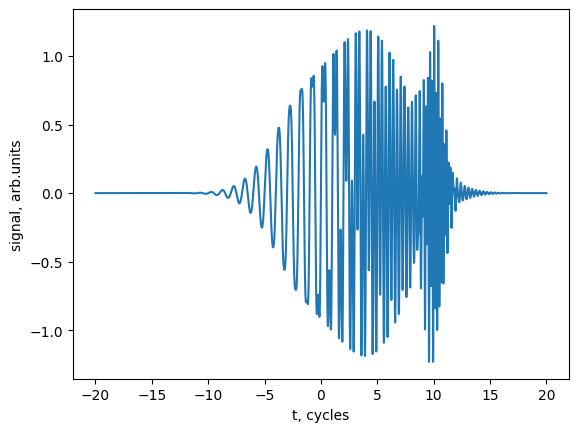

In [2]:
# generate the signal
nofts = 1000
N = 3**9 + 6

def generate_signal(N):
    t = np.linspace(-20 * 2 * pi, 20 * 2 * pi, N)
    y = np.sin(t) * exp(-(t**2) / 2 / 20**2)
    y = y + np.sin(3 * t) * exp(-((t - 5 * 2 * pi) ** 2) / 2 / 20**2)
    y = y + np.sin(5.5 * t) * exp(-((t - 10 * 2 * pi) ** 2) / 2 / 5**2)
    y2 = y + np.sin(4 * t) * exp(-((t - 7 * 2 * pi) ** 2) / 2 / 20**2)
    return t, y

#### original signal 
t, y = generate_signal(N)

#### new signal + (original sinal freq(4) shift(7))
y2 = y + np.sin(4 * t) * exp(-((t - 7 * 2 * pi) ** 2) / 2 / 20**2)

plt.plot(t / 2 / pi, y)
plt.xlabel("t, cycles")
plt.ylabel("signal, arb.units")
plt.show()

# Demonstrate windows

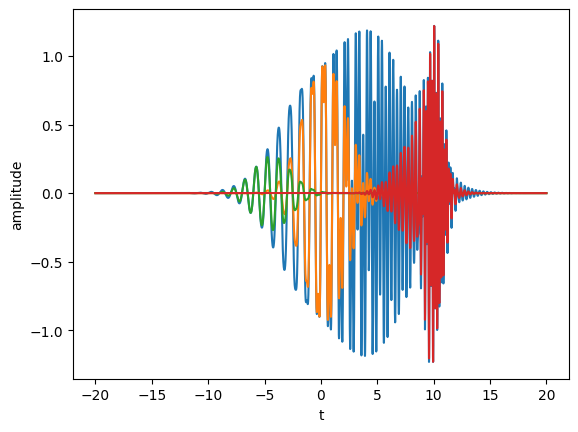

In [3]:
# windowed Fourier transform (Gabor transform, spectrogram)

window_width = 2.0 * 2 * pi
window_position = 0.0 * 2 * pi
window_function = exp(-((t - window_position) ** 2) / 2 / window_width**2)

y_window = y * window_function

plt.plot(t / 2 / pi, y)
plt.plot(t / 2 / pi, y_window)
plt.xlabel("t")
plt.ylabel("amplitude")
# plt.show()


# now do the same for different window positions and plot 2D graph
def window_map(signal, time, window_position, window_width=2.0 * 2 * pi):
    return signal * exp(-((time - window_position) ** 2) / 2 / window_width**2)


plt.plot(t / 2 / pi, window_map(y, t, -6 * 2 * pi))
plt.plot(t / 2 / pi, window_map(y, t, 10 * 2 * pi))
plt.show()

# Windows and fft

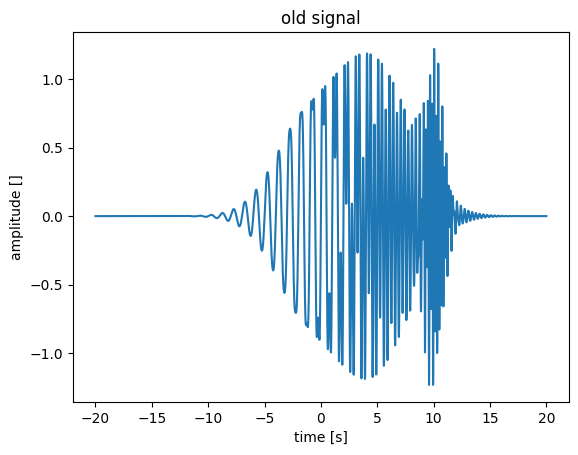

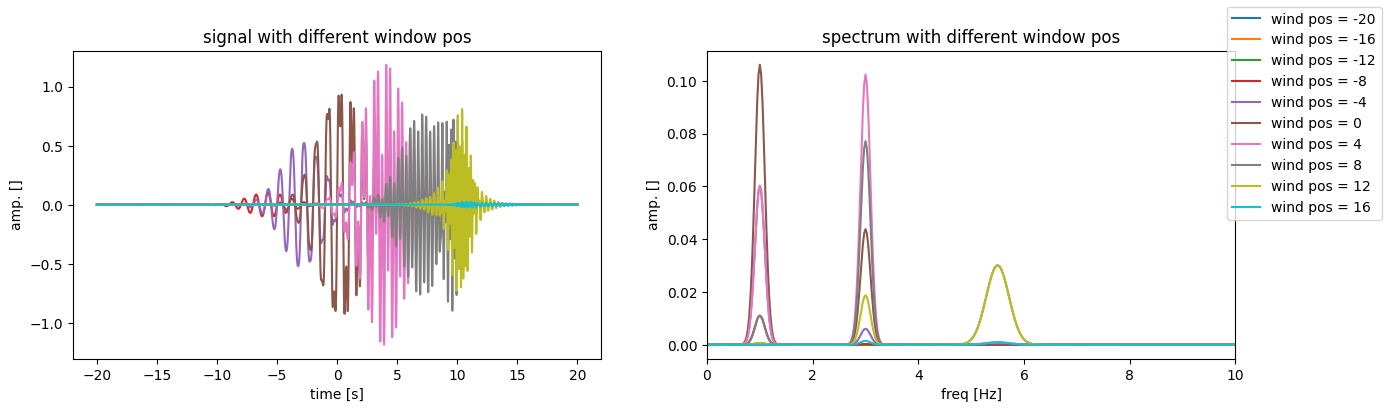

New signal (+sinal freq(4) shift(7))


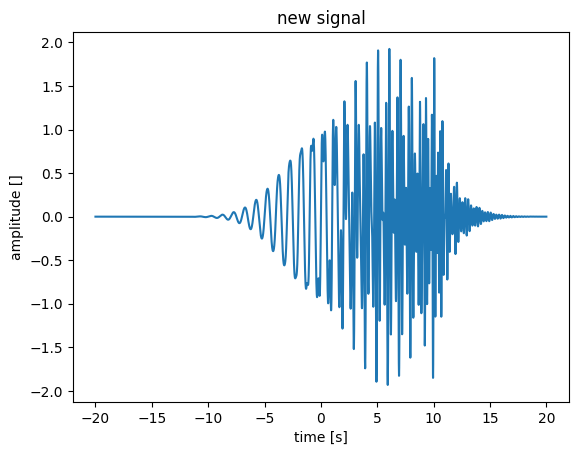

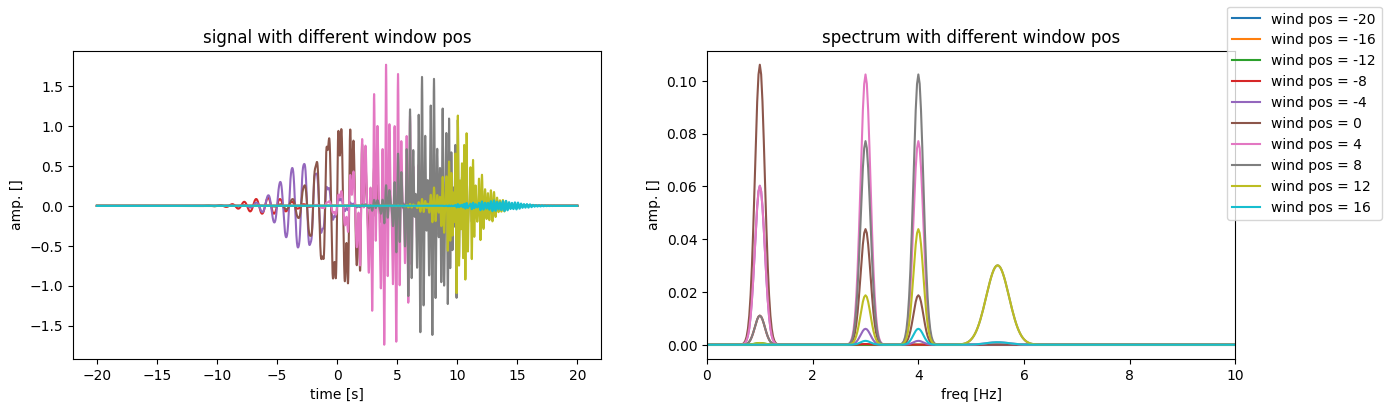

In [4]:
def loop(y, t, freq_itter, visual=False):
    """
    take signal y. Map y with the window. Do fft over the window. put fft as the column in return matrix Z.
    So Z contains column_i as fft_i of window_i.
    If visual you will see the procedure.
    return 
        time_points - just list of t_i,
        freq - list of freq from fftfreq,
        Z - matrix freq by time_points, contains column_i as fft_i of window_i 
    """
    if visual:
        fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    Time = np.arange(-20, 20, freq_itter)
    freq_fft = fft.fftfreq(len(y), d=(t[1] - t[0]) / 2 / pi)
    freq_fft = freq_fft[: len(freq_fft) // 2]

    fft_list = []

    for time in Time:
        window = window_map(y, t, time * 2 * pi)

        window_fft = fft.fft(window)
        window_fft = window_fft[: len(window_fft) // 2]
        window_fft = 2.0 / N * abs(window_fft)
        if visual:
            ax[0].plot(t / 2 / pi, window)
            ax[1].plot(freq_fft, window_fft, label=f"wind pos = {time}")

        fft_list.append(window_fft)
    if visual:
        ax[1].set_xlim(0, 10)
        ax[0].set_title("signal with different window pos")
        ax[0].set_xlabel("time [s]")
        ax[0].set_ylabel("amp. []")
        ax[1].set_title("spectrum with different window pos")
        ax[1].set_xlabel("freq [Hz]")
        ax[1].set_ylabel("amp. []")
        fig.legend()
        plt.show()
    Z = np.vstack(fft_list).T
    return Time, freq_fft, Z


plt.plot(t / 2 / pi, y)
plt.xlabel("time [s]")
plt.ylabel("amplitude []")
plt.title("old signal")
_ = loop(y, t, 4, visual=True)

print("New signal (+sinal freq(4) shift(7))")
plt.plot(t / 2 / pi, y2)
plt.xlabel("time [s]")
plt.ylabel("amplitude []")
plt.title("new signal")

_ = loop(y2, t, 4, visual=True)

# Spectrogram

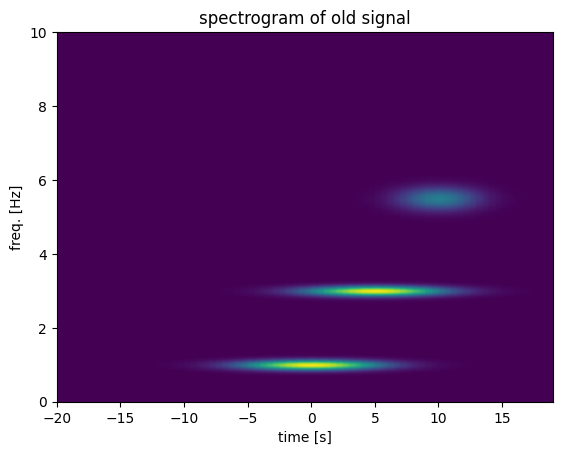

In [5]:
time, freq, Z = loop(y, t, 1)
plt.pcolormesh(time, freq, Z, shading="gouraud")
plt.ylim(0, 10)
plt.title("spectrogram of old signal")
plt.ylabel("freq. [Hz]")
plt.xlabel("time [s]")
plt.show()

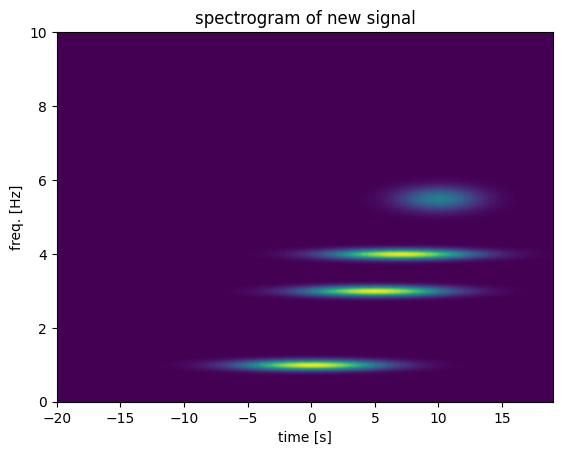

In [6]:
time, freq, Z = loop(y2, t, 1)
plt.pcolormesh(time, freq, Z, shading="gouraud")
plt.ylim(0, 10)
plt.title("spectrogram of new signal")
plt.ylabel("freq. [Hz]")
plt.xlabel("time [s]")
plt.show()

# Compute performance

In [7]:
import time as timer

performance_list = []
max_itter = 1000
n_list = 2 ** np.arange(2, 15)
for n in n_list:
    time, signal = generate_signal(n)
    start_time = timer.perf_counter()

    for i in range(max_itter):
        loop(signal, time, 10)
    performance_list.append((timer.perf_counter() - start_time) / max_itter)

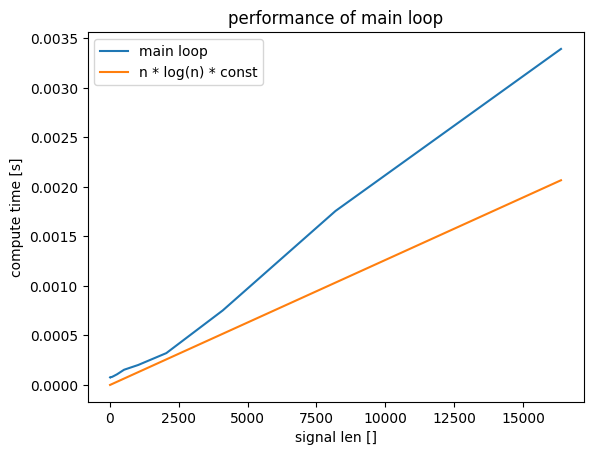

In [8]:
plt.plot(n_list, performance_list, label="main loop")
plt.plot(n_list, n_list * np.log(n) * 1e-8 * 1.3, label="n * log(n) * const")
plt.legend()
plt.title("performance of main loop")
plt.ylabel("compute time [s]")
plt.xlabel("signal len []")
plt.show()

## fft is proportional to n * log(n) where n is the len(signal)